In [4]:
import pandas as pd

Наши новости

In [5]:
ndir = "/content/drive/MyDrive/articles.csv"
news = pd.read_csv(ndir)
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [6]:
usdir = "/content/drive/MyDrive/users_articles.csv"
users = pd.read_csv(usdir)
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [7]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [8]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
!pip install razdel
from razdel import tokenize #https://github.com/natasha/razdel
!pip install pymorphy2
import pymorphy2


In [9]:
import nltk
nltk.download('stopwords')
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
dir = "/content/drive/MyDrive/stopwords.txt"

In [12]:
with open(dir) as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
new_stop = ['nn', 'nnthe']
stopword_ru += new_stop
len(stopword_ru)

778

In [13]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [14]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


CPU times: user 30.7 s, sys: 1.45 s, total: 32.1 s
Wall time: 39.2 s


In [15]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 3min 52s, sys: 602 ms, total: 3min 52s
Wall time: 3min 53s


А теперь в 3 строчки обучим нашу модель

In [16]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, примерно, тыс, назад, территория, совре...
Name: title, Length: 27000, dtype: object

In [17]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [18]:
common_dictionary[10]

'взаимодействие'

In [19]:
common_corpus

[[(0, 2),
  (1, 1),
  (2, 2),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 4),
  (16, 1),
  (17, 1),
  (18, 4),
  (19, 1),
  (20, 1),
  (21, 3),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 2),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 2),
  (45, 1),
  (46, 2),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 3),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 3),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 3),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 3),
  (89, 2),
  (90, 1)],
 [(91, 2

Все просто - это словарь наших слов

Запускаем обучение

In [20]:
from gensim.models import LdaModel

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
news['title_for_tfidf'] = news['title']

In [23]:
for ind in range (len(news)):
  news['title_for_tfidf'][ind] = ', '.join(w for w in news['title'][ind])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
tfidf = TfidfVectorizer(max_df=0.9, max_features=1000)
vals = tfidf.fit_transform(news['title_for_tfidf'])
features = tfidf.get_feature_names()
tfidf_df = pd.DataFrame(vals.toarray(), columns=features)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [25]:
tfidf_df.head()

,nnn,nthe,ru,run,авиакомпания,авиация,автомобиль,автор,агентство,адвокат,администрация,актив,активно,активный,акция,александр,алексей,альянс,американец,американский,анализ,аналитик,аналогичный,андрей,аппарат,арест,армия,атака,аэропорт,база,банк,баррель,безопасность,белоруссия,белый,бизнес,благодаря,близкий,блок,боевик,...,фсб,характер,ход,хороший,хотеть,хотя,цб,целое,цель,цена,центр,центральный,церковь,цитировать,час,частный,часто,частый,часть,четыре,чиновник,член,чёрный,шаг,шесть,школа,штаб,штат,экипаж,экономика,экономический,эксперт,экспорт,этап,южный,юрий,ядерный,язык,якобы,япония
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.164152,0.095947,0.0,0.0,0.0,0.0,0.0,0.0,0.197539,0.0,0.0,0.0,0.0,0.0,0.0,0.103689,0.0,0.0,0.0,0.0,0.0,0.0,0.079491,0.121539,0.0,...,0.128523,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.102239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.273702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.495423,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.133331,0.0,0.0,0.159733,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.18135,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.179758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0


In [26]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 45.2 s, sys: 21.9 s, total: 1min 7s
Wall time: 42.7 s


In [27]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [28]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(2, 0.25767803), (9, 0.5551074), (15, 0.08209226), (22, 0.08463443)]

[(47, 1),
 (99, 1),
 (103, 2),
 (104, 1),
 (115, 1),
 (124, 1),
 (125, 1),
 (126, 1),
 (127, 1),
 (128, 1),
 (129, 1),
 (130, 1),
 (131, 1),
 (132, 2),
 (133, 1),
 (134, 1),
 (135, 1),
 (136, 1),
 (137, 1),
 (138, 1),
 (139, 1),
 (140, 1),
 (141, 1),
 (142, 1),
 (143, 1),
 (144, 1),
 (145, 1),
 (146, 2),
 (147, 1),
 (148, 1),
 (149, 1),
 (150, 1),
 (151, 1),
 (152, 3),
 (153, 1)]

In [29]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: тело женщина день мужчина пенсия всё солнце
topic_1: американский журнал сша взрыв выяснить nasa первый
topic_2: район сотрудник москва убийство задержать рейс расчёт
topic_3: газ россия нефть операция российский ракета государство
topic_4: луна земля учёный всё северный день исследователь
topic_5: рак клетка лечение производитель риск офицер опухоль
topic_6: военный самолёт армия россия российский космический советский
topic_7: рост наука эксперт проект россия новый общество
topic_8: ребёнок тыс статья россия около пострадать миссия
topic_9: смерть организм египет жизнь всё миллиард трагедия
topic_10: гражданин сша пациент помощь расследование статья данные
topic_11: поверхность поток восток стоимость автомобиль вирус образоваться
topic_12: мозг день учёный письмо глава житель совет
topic_13: планета жизнь возраст книга астероид заболевание собака
topic_14: млрд рубль россия цена руб млн объём
topic_15: научный учёный исследование система сша исследователь снижение
topic_16: 

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [30]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [31]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.122255,0.0,0.035778,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.834248,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,4896,0.0,0.471673,0.133896,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.271665,0.0,0.039005,0.000000,0.000000,0.064249,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,4897,0.0,0.000000,0.257674,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.555109,0.0,0.000000,0.000000,0.000000,0.000000,0.082112,0.000000,0.0,0.0,0.0,0.0,0.0,0.084617,0.000000,0.000000
3,4898,0.0,0.000000,0.000000,0.000000,0.0,0.032162,0.000000,0.049786,0.0,0.424561,0.0,0.000000,0.021382,0.017234,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.025035,0.183577,0.231207
4,4899,0.0,0.000000,0.000000,0.236013,0.0,0.000000,0.502127,0.000000,0.0,0.125976,0.0,0.000000,0.000000,0.000000,0.113181,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [ ]:
users.head(3)

In [32]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [ ]:
doc_dict[293622]

In [49]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list, func='mean'):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if func == 'max':
      user_vector = np.max(user_vector, 0)
    if func == 'median':
      user_vector = np.median(user_vector, 0)
    else:
      user_vector = np.mean(user_vector, 0)
    return user_vector

In [51]:
get_user_embedding(user_articles_list, "median")

array([0.        , 0.        , 0.01340278, 0.14925754, 0.        ,
       0.        , 0.        , 0.03173741, 0.01222198, 0.        ,
       0.03508088, 0.        , 0.        , 0.        , 0.        ,
       0.01047433, 0.        , 0.        , 0.        , 0.06653259,
       0.        , 0.        , 0.        , 0.        , 0.09402942])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [35]:
user_embeddings_mean = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings_mean.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_mean['uid'] = users['uid'].values
user_embeddings_mean = user_embeddings_mean[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.014219,0.039718,0.070702,0.084303,0.000000,0.021288,0.003461,0.001693,0.122695,0.000000,0.018749,0.012924,0.072907,0.024747,0.030679,0.000000,0.000000,0.024105,0.007166,0.056147,0.000000,0.063327,0.129424,0.130801,0.053453
1,u108690,0.031276,0.019808,0.051672,0.096425,0.055125,0.020387,0.002600,0.009982,0.122743,0.014006,0.016917,0.014243,0.060393,0.003710,0.090411,0.064753,0.009428,0.002063,0.000000,0.061017,0.001914,0.006664,0.009235,0.107734,0.112014
2,u108339,0.041494,0.030974,0.121886,0.129099,0.087537,0.010684,0.021176,0.008137,0.120339,0.008210,0.054352,0.003288,0.039259,0.002153,0.078470,0.032000,0.032845,0.033994,0.004438,0.060801,0.000000,0.002118,0.034647,0.000000,0.028356


In [36]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, 'median'), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.012741,0.017134,0.013244,0.064809,0.0,0.005573,0.000000,0.000000,0.114332,0.000000,0.000000,0.000000,0.066873,0.0,0.008091,0.000000,0.000000,0.000000,0.0,0.046826,0.0,0.017711,0.131590,0.000000,0.044972
1,u108690,0.018047,0.006846,0.021584,0.048629,0.0,0.000000,0.000000,0.000000,0.108004,0.013415,0.000000,0.008073,0.046216,0.0,0.076396,0.059309,0.000000,0.000000,0.0,0.063860,0.0,0.005167,0.000000,0.026128,0.091848
2,u108339,0.025854,0.006481,0.108903,0.137223,0.0,0.000000,0.005529,0.006105,0.107390,0.007604,0.045408,0.000000,0.034202,0.0,0.028051,0.034652,0.020212,0.015991,0.0,0.057734,0.0,0.000000,0.009793,0.000000,0.007543


In [52]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, 'max'), 1)])
#user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
#user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_max.head(3)

,0,uid
0,0.126765,u105138
1,0.114643,u108690
2,0.104201,u108339


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [56]:
tardir = "/content/drive/MyDrive/users_churn.csv"
target = pd.read_csv(tardir)
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [57]:
X_m = pd.merge(user_embeddings_mean, target, 'left')
X_m.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.014219,0.039718,0.070702,0.084303,0.000000,0.021288,0.003461,0.001693,0.122695,0.000000,0.018749,0.012924,0.072907,0.024747,0.030679,0.000000,0.000000,0.024105,0.007166,0.056147,0.000000,0.063327,0.129424,0.130801,0.053453,0
1,u108690,0.031276,0.019808,0.051672,0.096425,0.055125,0.020387,0.002600,0.009982,0.122743,0.014006,0.016917,0.014243,0.060393,0.003710,0.090411,0.064753,0.009428,0.002063,0.000000,0.061017,0.001914,0.006664,0.009235,0.107734,0.112014,1
2,u108339,0.041494,0.030974,0.121886,0.129099,0.087537,0.010684,0.021176,0.008137,0.120339,0.008210,0.054352,0.003288,0.039259,0.002153,0.078470,0.032000,0.032845,0.033994,0.004438,0.060801,0.000000,0.002118,0.034647,0.000000,0.028356,1


In [58]:
X_med = pd.merge(user_embeddings_median, target, 'left')
X_med.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.012741,0.017134,0.013244,0.064809,0.0,0.005573,0.000000,0.000000,0.114332,0.000000,0.000000,0.000000,0.066873,0.0,0.008091,0.000000,0.000000,0.000000,0.0,0.046826,0.0,0.017711,0.131590,0.000000,0.044972,0
1,u108690,0.018047,0.006846,0.021584,0.048629,0.0,0.000000,0.000000,0.000000,0.108004,0.013415,0.000000,0.008073,0.046216,0.0,0.076396,0.059309,0.000000,0.000000,0.0,0.063860,0.0,0.005167,0.000000,0.026128,0.091848,1
2,u108339,0.025854,0.006481,0.108903,0.137223,0.0,0.000000,0.005529,0.006105,0.107390,0.007604,0.045408,0.000000,0.034202,0.0,0.028051,0.034652,0.020212,0.015991,0.0,0.057734,0.0,0.000000,0.009793,0.000000,0.007543,1


In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [66]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X_m[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_m['churn'], random_state=0)

In [67]:
X_train_med, X_test_med, y_train_med, y_test_med = train_test_split(X_med[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_med['churn'], random_state=0)

In [80]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [81]:
lg_med = LogisticRegression()

In [82]:
lg_med.fit(X_train_med, y_train_med)

LogisticRegression()

In [83]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.30430098, 0.04271155, 0.53107038, 0.2371899 , 0.00852965,
       0.04890683, 0.16143422, 0.02551452, 0.16629955, 0.14201267])

In [84]:
preds_med = lg_med.predict_proba(X_test_med)[:, 1]
preds[:10]

array([0.30430098, 0.04271155, 0.53107038, 0.2371899 , 0.00852965,
       0.04890683, 0.16143422, 0.02551452, 0.16629955, 0.14201267])

In [85]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [91]:
import itertools

In [86]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.268010, F-Score=0.653, Precision=0.610, Recall=0.702


In [88]:
precision_med, recall_med, thresholds_med = precision_recall_curve(y_test_med, preds_med)
fscore_med = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix_med = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_med[ix_med], 
                                                                        fscore_med[ix_med],
                                                                        precision_med[ix_med],
                                                                        recall_med[ix_med]))

Best Threshold=0.262470, F-Score=0.717, Precision=0.659, Recall=0.788


In [89]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1641  114]
 [  72  173]]


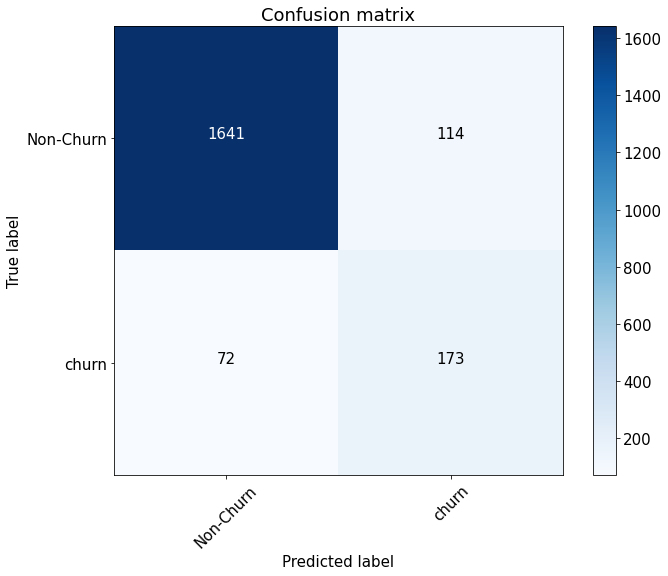

In [92]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [93]:
roc_auc_score(y_test, preds)

0.9334356648642363

Confusion matrix, without normalization
[[1655  100]
 [  53  192]]


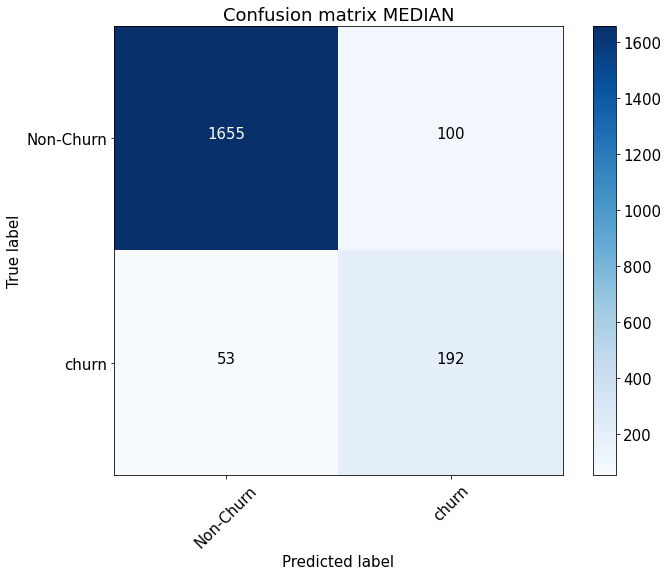

In [94]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_med = confusion_matrix(y_test_med, preds_med>thresholds_med[ix_med])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_med, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix MEDIAN')
plt.savefig("conf_matrix_MEDIAN.png")
plt.show()

In [95]:
roc_auc_score(y_test_med, preds_med)

0.9603535089249375